In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pickle
import random

In [2]:
## Load the map
#img_name = "Reduced Size Map.npy";
#field_map = Image.open(img_name);

file_name = "Reduced Size Map.npy";
#file_name = "Field Map.npy";
field_map = np.load(file_name);

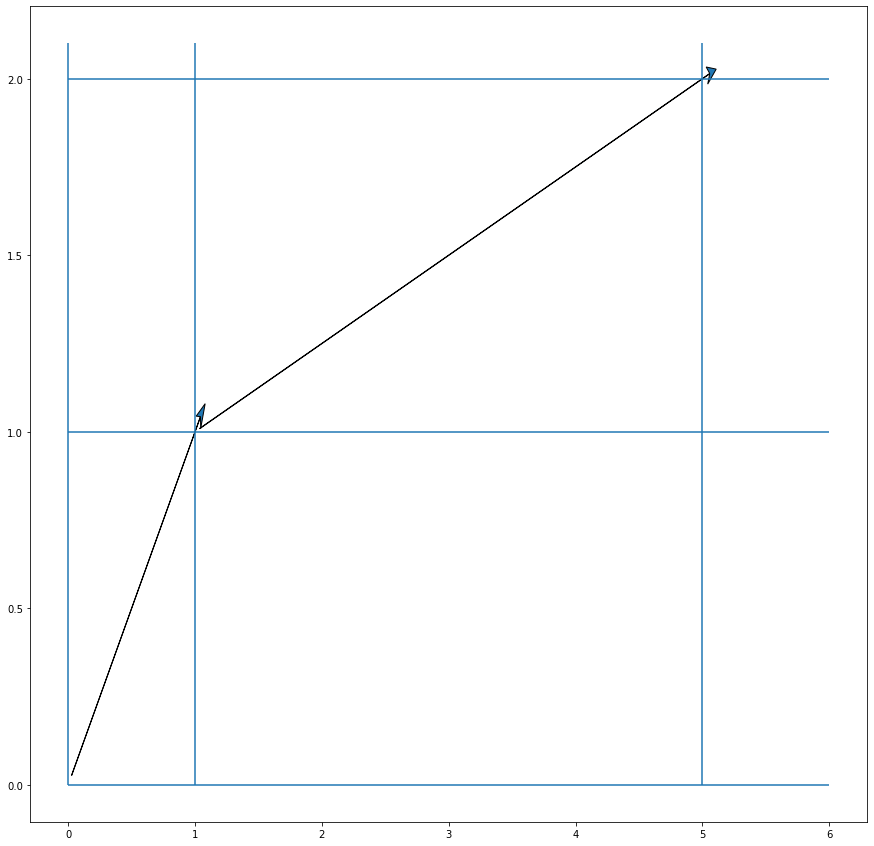

In [3]:
## Example showing implementation of arrow drawing for a drone path using a sequence of 3 points
x_pos = [0, 1, 5];
y_pos = [0, 1, 2];
plt.figure(figsize=(15,15));
[plt.arrow(x_pos[i], y_pos[i], x_pos[i + 1] - x_pos[i], y_pos[i + 1] - y_pos[i], \
           head_width = 0.001*50, overhang = 0.3, head_starts_at_zero = True) for i in range(len(y_pos) - 1)];
plt.hlines(0, 0, 6);
plt.hlines(1, 0, 6);
plt.hlines(2, 0, 6);

plt.vlines(0, 0, 2.1);
plt.vlines(1, 0, 2.1);
plt.vlines(5, 0, 2.1);


In [4]:
## Load the sensor locations
with open('sensors.pkl', 'rb') as file:
    loc = pickle.load(file);
    loc = np.array(loc); # sensor locations are stored in loc
print(np.shape(loc));
print(loc);

(1269, 2)
[[150 150]
 [150 149]
 [141 140]
 ...
 [196  41]
 [ 30  86]
 [290 163]]


In [5]:
## Example for creating drone travel sequence

drone_coverage = [];
for i in range(4):
    drone_coverage.append([]);
print(drone_coverage);
drone_coverage[0].append(2);
drone_coverage[2].append(51);
drone_coverage[2].append(7);
print(drone_coverage);
x = [5];
x.append(4);
x.append(6);
x = x + [1, 2, 3]
print(x);

[[], [], [], []]
[[2], [], [51, 7], []]
[5, 4, 6, 1, 2, 3]


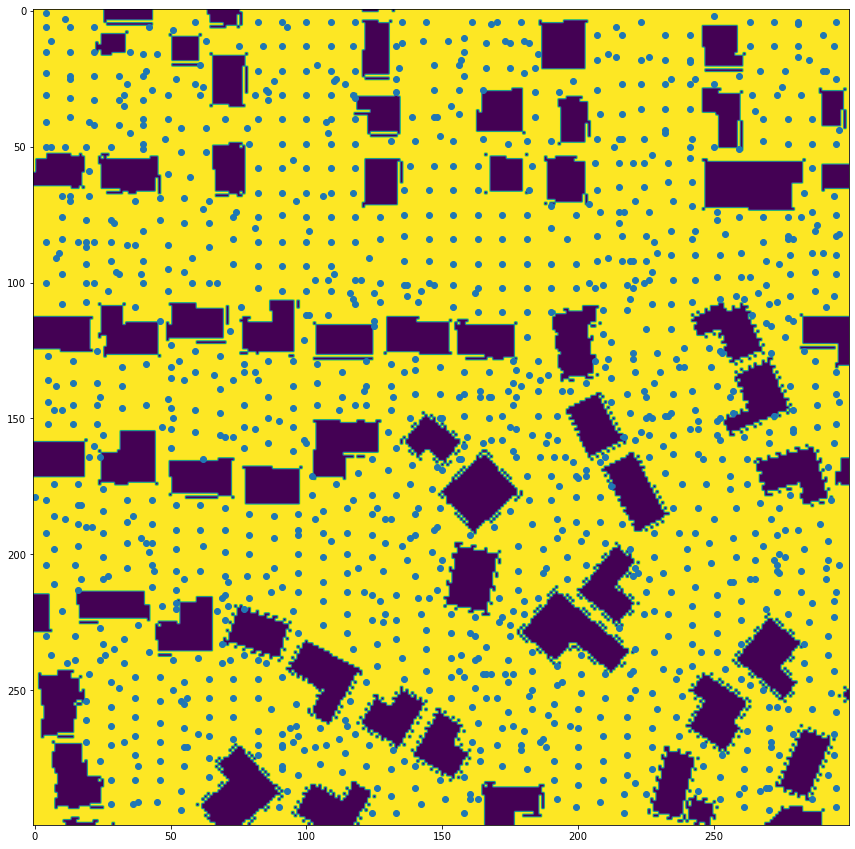

In [6]:
## Plotting sensor locations on map

plt.rcParams["figure.figsize"] = (15, 15);
implot = plt.imshow(field_map);
plt.rcParams["figure.figsize"] = (15, 15);
plt.scatter(loc[:, 1], loc[:, 0]);
plt.rcParams["figure.figsize"] = (15, 15);
plt.show();
plt.rcParams["figure.figsize"] = (15, 15);

In [7]:
# Test of sensor location definition
print(loc[0]);
print((150, 150));
print(len((150, 150)));
print(loc[0] == (150, 150));

[150 150]
(150, 150)
2
[ True  True]


In [8]:
## Helper Functions
#Inputs are two tuples, returns the distance between the two points
#If loc is inputted, first two inputs are taken to be indices in loc
def getDistance( input1, input2, loc = [] ):
    #If len is not passed in, we check if input1 and input2 are tuple points
    if (len(loc) == 0):
        #if no points passed
        if ((not np.shape(input1)) and (not np.shape(input2))):
            return -1;
        else:
            pt1 = input1;
            pt2 = input2;
            return ((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)**(0.5);
            
    #Otherwise assume input1 and input2 are indices in loc
    else:
        ind1 = input1;
        ind2 = input2;
        if (ind1 >= 0 and ind2 >= 0 and ind1 < len(loc) and ind2 < len(loc) and ind1 != ind2):
            pt1 = loc[ind1,:];
            pt2 = loc[ind2,:];
            return ((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)**(0.5);
        else:
            return -1;

#distances between all points - v2: getDistance(ind1,ind2,loc)
def getDistanceMatrix(nodes, loc = []):
#loc = array of tupples - includes locations of points to obtain distances for
#returns upper triangular matrix
    N = len(nodes) #number of sensors
    dist = np.zeros((N, N));
    for i in range(0, N): #go through all points # note: range goes from 0 to N-1 in this case
        for j in range(0, i):
            if (len(loc) == 0):
                distance = getDistance(nodes[i], nodes[j]);
            else:
                distance = getDistance(nodes[i], nodes[j], loc);
            dist[i,j] = distance;
            dist[j,i] = distance; 
    return(dist);

#Function to find root of next spanning tree (of new cluster)
def rt_next_cluster(x, y, locations):
    #Inputs: x,y = location of a single point where the drone is
            #sensors = and a list of m points that are in the new cluster
    min_dist_found = float('inf');
    min_dist_pt = -1; 
    current_loc = [x,y]
    for i in range(0, len(locations)):
        dest_x_val = locations[i][0];
        dest_y_val = locations[i][1];
        if (dest_x_val != x) or (dest_y_val !=y): #check you aren't attempting to move to same point
            dest_loc = [dest_x_val, dest_y_val];
            dist_considered = getDistance(current_loc, dest_loc)
            if dist_considered < min_dist_found:
                min_dist_found = dist_considered;
                min_dist_pt = i; #index of the point in locations that is closed to our current location
    return min_dist_pt;

#Function to create a minimum weight spanning tree
def getSpanningTree(nodes, root_index = -1, loc = []):
    N = len(nodes);
    #distances = getDistanceMatrix(nodes, loc);
    if (root_index == -1):
        root_index = random.randint(0, N);
    #Keep track of nodes added to tree
    tree = [];
    nodes_added = [0]*N;
    #Add root node first
    tree = addNode(tree, nodes[root_index], -1, loc);
    #Mark root index as added
    nodes_added[root_index] = 1;
    while (len(tree) < N):
        if (len(tree) % 100 == 0):
            print(len(tree));
        min_dist_considered = float('inf');
        min_i = -1;
        min_j = -1;
        #loop over points in tree
        for i in range(len(tree)):
            #check distance to all nodes not in tree, record min distance
                for j in range(len(nodes_added)):
                    #only look at points that are not added to tree
                    if (nodes_added[j] == 0):
                        #Check if distance between current pair is below minimum
                        dist_ij = getDistance(tree[i]["loc"], nodes[j], loc);
                        if (dist_ij < min_dist_considered):
                            min_dist_considered = dist_ij;
                            min_i = i;
                            min_j = j;
        #Add node with the min distance to tree
        tree = addNode(tree, nodes[min_j], min_i, loc);
    return tree;

#Function to add node to tree based for one parent
#If input2 is a node, then we add it right away. Otherwise we need to
#create the node first and then add it
#Parent is the index in tree of the parent node
#input 2 can either be a (1) node dictionary (don't use 3rd or 4th parameter)
#, (2) an integer representing an index in loc for the sensor location, or
#(3) a tuple representing the 2d location of the new node
def addNode(tree, input2, parent = -1, loc = []):
    #Check if second input is the node to add (dictionary type)
    if isinstance(input2, dict):
        node = input2;
    else:
        n_loc = input2;
        if (parent >= 0 and parent < len(tree)):
            dist_parent = getDistance(tree[parent]["loc"], n_loc, loc);
        else:
            dist_parent = -1;
            parent = -1;
        node = {"parent": parent, "children": [], "loc": n_loc, \
                    "dist_parent": dist_parent};
    tree.append(node)
    #Update children
    if (node["parent"] >= 0 and node["parent"] < len(tree) - 1):
        tree[tree[len(tree) - 1]["parent"]]["children"].append(len(tree) - 1);
    return tree;

#returns the index of the node in tree with parameter val. returns -1 if not found
def findNode(tree, val):
    for i in range(len(tree)):
        if (tree[i]["loc"] == val):
            return i;
    return -1;

#Pass through the indices of the spots that this drone travels, and the sensor locations
#returns total distance travelled by drone
def totalDistance(dronePath, loc = []):
    dist = 0;
    num_pts = len(dronePath);
    #If loc is not given, assume that the dronePath variable is a matrix
    #containing the sequence of all path points
    if (len(loc) == 0):
        for i in range(num_pts - 1):
            dist = dist + getDistance(dronePath[i], dronePath[i + 1]);
    else:
        for i in range(num_pts - 1):
            dist = dist + getDistance(dronePath[i], dronePath[i + 1], loc);
    return dist;

#Input is the min weight spanning tree, output is the preorder traversal list
#If no root location is given in the tree array, assume first node is root
def preorderTraversal(tree, root_index = 0):
    if (len(tree) == 0):
        return [];
    children = tree[root_index]["children"];
    num_children = len(children);
    traversal_cut = [tree[root_index]["loc"]];
    if num_children == 0:
        return traversal_cut;
    for i in range(num_children):
        traversal_cut = traversal_cut + preorderTraversal(tree, children[i]);
    return traversal_cut;

## Clustering
#Helper function to calculate objective function based on
#indicator variables r_nk and centers mu_ids
def getJ(r_nk, mu, loc):
    (N, K) = np.shape(r_nk);
    J = 0;
    for n in range(N):
        for k in range(K):
            J = J + (r_nk[n][k])*((getDistance(loc[n], mu[k]))**2);
    return J;
        
#K means Algorithm. Returns a tuple whose 
#first element is the centroids (mu), and
#second element is the centroid assignment matrix, size (len(loc) x K)
def KMeansClusters(K, loc):
    #Initialize centers using K++ means
    N = len(loc);
    mu = np.zeros((K, 2));
    mu[0,:] = loc[random.randint(0, N)];
    for i in range(1, K):
        #For each point, find how close it is to the closes centers
        distances = [float('inf')]*N;
        for j in range(N):
            #loop over existing centers
            for w in range(i):
                this_distance = getDistance(loc[j], mu[w]);
                if (this_distance < distances[j]):
                    distances[j] = this_distance;
        pt_to_add = np.argmax(distances);
        mu[i,:] = loc[pt_to_add];
    r_nk = -1;
    J = 0;
    J_next = -1;
    while (J_next != J):
        #Update J
        J = J_next;
        #Assign points to centers
        r_nk = np.zeros((N, K));
        for n in range(N):
            dist_to_mus = [0]*K;
            for k in range(K):
                dist_to_mus[k] = ((getDistance(loc[n], mu[k]))**2);
            mu_to_assign = np.argmin(dist_to_mus);
            r_nk[n][mu_to_assign] = 1;
        #Recalculate centers
        num_mu_groups = np.sum(r_nk, 0);
        for k in range(K):
            #Get points in center k
            i_n = 0;
            points_k = np.zeros((int(num_mu_groups[k]), 2));
            for n in range(N):
                if (r_nk[n][k] == 1):
                    points_k[i_n,:] = loc[n];
                    i_n = i_n + 1;
            #Average of points assigned to center k gives its new center
            if (i_n != num_mu_groups[k]):
                return -1;
            mu[k,:] = np.average(points_k, 0);
        #Recalculate new J
        J_next = getJ(r_nk, mu, loc);
    
    return (mu, r_nk);
    

[array([150, 150]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150, 149]), array([150,

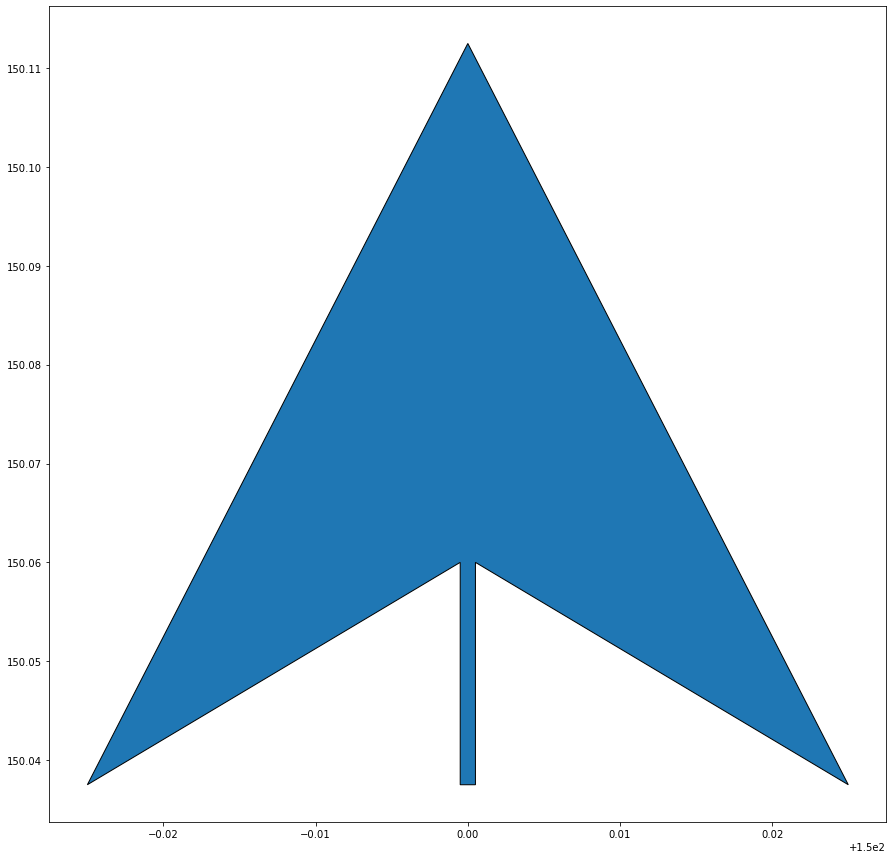

In [9]:
## Testing of min weight spanning tree
#Using all points takes too long
"""
min_span_tree_test = getSpanningTree(loc[:100], 0);
span_tree_traversal = preorderTraversal(min_span_tree_test);
print(span_tree_traversal);
x_pos = loc[:100][0];
y_pos = loc[:100][0];
plt.figure(figsize=(15,15));
[plt.arrow(x_pos[i], y_pos[i], x_pos[i + 1] - x_pos[i], y_pos[i + 1] - y_pos[i], \
           head_width = 0.001*50, overhang = 0.3, head_starts_at_zero = True) for i in range(len(y_pos) - 1)];
"""

(50, 2)
(1269, 50)


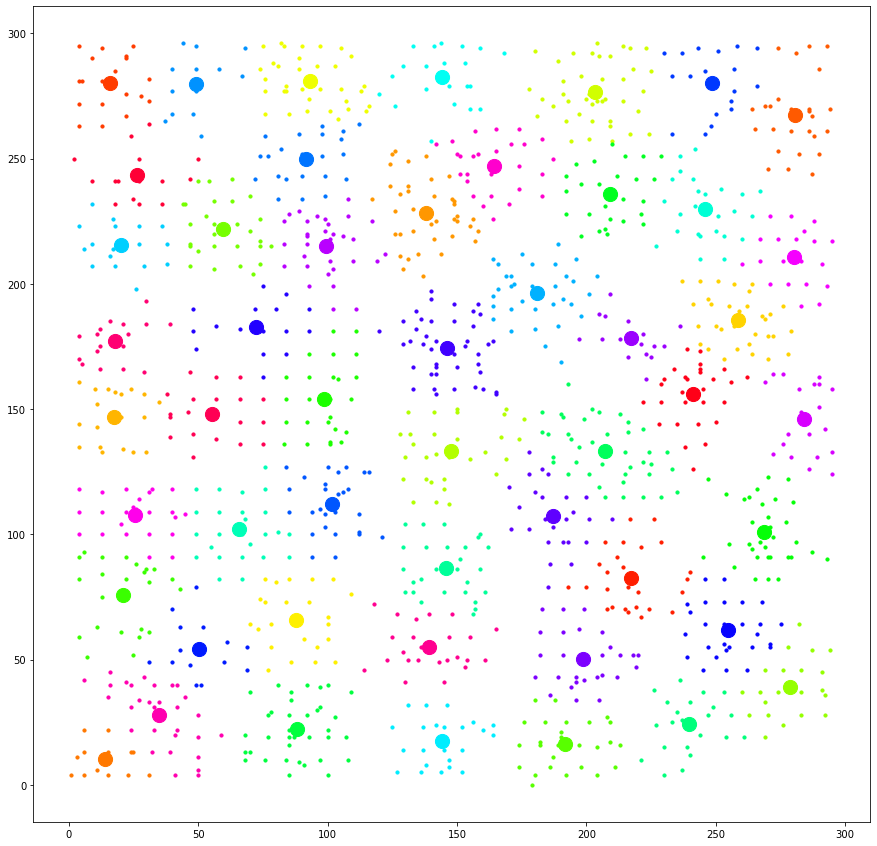

In [10]:
## Final testing for k means algorithm
N = len(loc);
K = 10;
(mu, r_nk) = KMeansClusters(K, loc);
print(np.shape(mu));
print(np.shape(r_nk));
#Generate k distinct colors
colors = plt.cm.get_cmap('hsv', K + 1);
num_groups = np.sum(r_nk, 0);
#Plot
for k in range(K):
    #plot center
    plt.scatter(mu[k][0], mu[k][1], s = 200, color = colors(k + 1));
    #plot data points
    i = 0;
    points_k = np.zeros((int(num_groups[k]), 2));
    for n in range(N):
        if (r_nk[n][k] == 1):
            points_k[i,:] = loc[n];
            i = i + 1;
    #Average of points assigned to center k gives its new center
    if (i != num_groups[k]):
        print("ERROR, i = ", i, " out of ", num_groups[k], " points in cluster ", k);
    plt.scatter(points_k[:,0], points_k[:,1], s = 10, color = colors(k + 1));
plt.show();


(4, 2)
(12, 4)


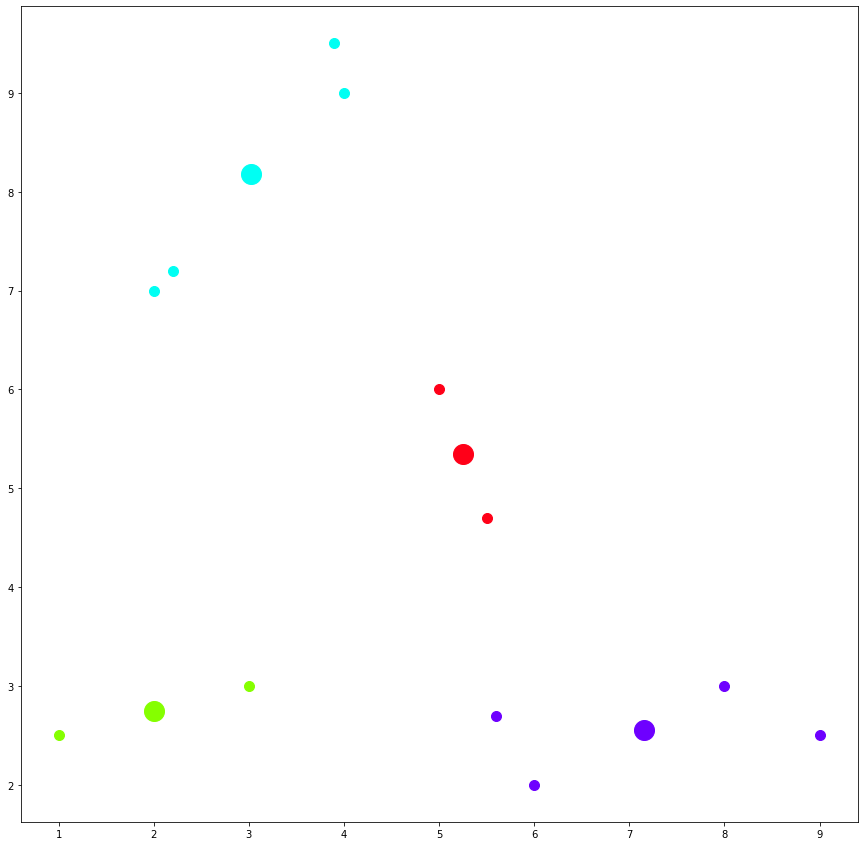

In [11]:
## Kmeans test with tuples
temp_tuples = [(1.0, 2.5), (5.6, 2.7), (3.9, 9.5), (5.5, 4.7), (2.2, 7.2), \
               (4, 9), (3, 3), (5, 6), (9, 2.5), (8, 3), (6, 2), (2, 7)];
N = len(temp_tuples);
K = 4;
(mu, r_nk) = KMeansClusters(K, temp_tuples);
print(np.shape(mu));
print(np.shape(r_nk));
#Generate k distinct colors
colors = plt.cm.get_cmap('hsv', K + 1);
num_groups = np.sum(r_nk, 0);
#Plot
for k in range(K):
    #plot center
    plt.scatter(mu[k][0], mu[k][1], s = 400, color = colors(k + 1));
    #plot data points
    i = 0;
    points_k = [];
    for n in range(N):
        if (r_nk[n][k] == 1):
            points_k.append(temp_tuples[n]);
            i = i + 1;
    #Average of points assigned to center k gives its new center
    if (i != num_groups[k]):
        print("ERROR, i = ", i, " out of ", num_groups[k], " points in cluster ", k);
    this_x = [];
    this_y = [];
    for a in range(len(points_k)):
        this_x.append(points_k[a][0]);
        this_y.append(points_k[a][1]);
    plt.scatter(this_x, this_y, s = 100, color = colors(k + 1));
plt.show();

In [12]:
## Example of preorder traversal
graph = [];
graph = addNode(graph, "a", -1); #0
graph = addNode(graph, "b", 0); #1
graph = addNode(graph, "c", 1); #2
graph = addNode(graph, "e", 0); #3
graph = addNode(graph, "f", 3); #4
graph = addNode(graph, "g", 3); #5
graph = addNode(graph, "d", 1); #6
graph = addNode(graph, "w", 0); #7
graph = addNode(graph, "z", 7); #8
graph = addNode(graph, "x", 4); #9
graph = addNode(graph, "y", 4); #10
graph = addNode(graph, "o", 10); #11
graph_traversal = preorderTraversal(graph);
print(graph_traversal);

['a', 'b', 'c', 'd', 'e', 'f', 'x', 'y', 'o', 'g', 'w', 'z']


In [13]:
## Example of adding nodes to spanning tree in scenario 1
drone_spanning = [];
drone_spanning = addNode(drone_spanning, (150, 150), -1); #0
drone_spanning = addNode(drone_spanning, (175.5, 142.1), 0); #1

In [14]:
#Return list of points travelled to by big drone
def single_route(loc):
    # write a function that designs the route of the big drone in scenario 1
    t = 0;
    ## See report for pseudocode
    return t;

#Return list of points travelled to by each drone (drone_coverage)
def routes(m, loc):
    dist = 0;
    # write a function that designs the paths for the m drones to minimize the tota deployment time
    # return the deployment time
    
    #Create m clusters for m drones
    (mu, clust) = KMeansClusters(m, loc);
    
    #Assign drones to clusters - each cluster label = that drone index
    drones = [];
    for i in range(0,m): # iterate through each column of the cluster matrix
        drones.append(i);
    #find distance traveled by each drone
        #use getDistance to determine center of map to cluster, distances between points in clusters & travel time back to center
    #compare total distances for each drone
        #drone with shortest distance then goes to cluster that requires longest distance 
    #Have drones traverse through their clusters using min weight spanning tree method- essentially the same thing but happening M times on smaller scales
    return dist;

routes(3, loc); 

def simplify_graph(loc):
    # optional: write a function to simplify the map graph by ignoring some paths
    return True;

# You can choose any data structure you think best to represent nodes, graphs, and any other data types.

In [15]:
## Main Function
M = [1, 3, 5, 8, 10]; #M = number of drones
plt.plot(M,dep_time);
plt.xlabel('Number of Drones Used');
plt.ylabel('Total Deployment Time');
plt.legend(['Node Placement According to our Algorithm', 'Random Node Placement'], \
           bbox_to_anchor =(1, 0.75));
plt.title('Notion 1 of Connectivity');
plt.show();
#ploting drone trajectories
#plot sensor locations 
array = [[0]*3]
print(array);

In [ ]:
def node_match(v, con_seg, edges):
    # given a vertex, connected segment (list) and edges in graph (array)
    #returns whether that vertex is connected to an edge in the connected segment
    for i in range(0, len(con_seg)): #iterate through each edge in connection
        edge_idx = con_seg[i]; #index to be used in distances matrix (retrieved from connection list)
        for j in range(0, 2): #iterate through 
            if v == edges[edge_idx][j]:
                return True;
    return False;

In [ ]:
class Edge:
    
    def __init__(self, src_index, dst_index, value):
        self.src_index = src_index
        self.dst_index = dst_index
        self.value = value
    
    def hasSameNodes(self, e):
        return (self.src_index == e.src_index and self.dst_index == e.dst_index) or (self.src_index == e.dst_index and self.dst_index == e.src_index)


def getExampleEdgeMatrix(n):
    m = np.zeros((n,n))
    val = 1
    for i in range(n):
        for j in range(i + 1, n):
            m[i, j] = val
            val += 1
    return m

# gets unique (no duplicates) edges sorted by edge weight
def getUniqueSortedEdges(node_indices_a, node_indices_b, edge_matrix, least_to_greatest=True):
    edges = []
    for i in node_indices_a:
        for j in node_indices_b:
            e = None
            if i < j:
                e = Edge(i, j, edge_matrix[i, j])
            elif i > j:
                e = Edge(j, i, edge_matrix[j, i])
            if e is not None:
                duplicate_edge = False
                for other_edge in edges:
                    if e.hasSameNodes(other_edge):
                        duplicate_edge = True
                        break
                if not duplicate_edge:
                    edges.append(e)
    edges.sort(key=lambda e: e.value, reverse=(not least_to_greatest))
    return edges

def getNumpyIndicesFromEdges(edge_objects):
    indices = np.zeros((len(edge_objects), 2))
    for i, e in enumerate(edge_objects):
        indices[i, 0] = e.src_index
        indices[i, 1] = e.dst_index
    return indices

In [ ]:
node_indices_a = [];
for i in range(0,len(loc)):
    node_indices_a.append(i);
edge_objects = getUniqueSortedEdges(node_indices_a, node_indices_a, dist, True);
edge_arr = getNumpyIndicesFromEdges(edge_objects);
print(array);

ind1 = array[0,0];
ind2 = array[0,1];
inda = array[len(loc)-1, 0];
indb = array[len(loc)-1, 1];
print(dist[ind1, ind2]);
print(dist[inda, indb]);

In [ ]:
###test of class
test =getExampleEdgeMatrix(15);
print(test);
node_indices_a = [2,5];
node_indices_b = [3,7,10];

edge_objects = getUniqueSortedEdges(node_indices_a, node_indices_b, test, True);
array = getNumpyIndicesFromEdges(edge_objects);
print(array);

In [ ]:
#Melody Test

#set up array to store sensor edges that are connected, and ensure graph is acyclic
#def min_w_span_tree(): ## not put into function form yet

c = [];
c.append(ordered_edges[0]);#min weight edge included by default
print(c);
#np.insert(c,1,[ordered_edges[1]],axis = 0); #note: axis = 0 --> add row-wise

for z in range(0, len(ordered_edges)): #look at each edge in order from min to max weight
    for b in range (0, len(c)): # look at each connected group
        nodeA = ordered_edges[z,0]; #get vertices connected to the edge of interest
        nodeB = ordered_edges[z,1];
        A_in_c_seg = node_match(nodeA,c[b], ordered_edges); #determine if vertices are in this connected segment
        B_in_c_seg = node_match(nodeB,c[b], ordered_edges);
           
        #if one node is a part of a connected piece and the other is not
        if ((A_in_c_seg == True) and (B_in_c_seg == False)):
            #check if the other is connected to another segment
            con_seg = False;
            for k in range (0, len(c)): # look at each connected group
                B_in_c = node_match(nodeB, c[k], ordered_edges);
                if B_in_c == True:
                    #combine segments
                    if k<b: #put b's segment into k and then delete b
                        for f in range(0,c[b]):
                            c[k].append(c[b,f]);
                            c[b,f] = -1;
                    else: #put k's segment into b and then delete k
                        for f in range(0, c[k]):
                            c[b].append(c[k,f]);
                            c[k,f] = -1;
                    con_seg = True;
                    break;
            if con_seg == False: #B isn't in the other segment 
                c[b].append[nodeB]; #append edge index to the connected segment that has a node in common
        if ((A_in_c_seg == False) and (B_in_c_seg == True)):
            #check if the other is connected to another segment
            con_seg = False;
            for k in range (0, len(c)): # look at each connected group
                A_in_c = node_match(nodeA, c[k], ordered_edges);
                if A_in_c == True:
                    #combine segments
                    if k<b: #put b's segment into k and then delete b
                        for f in range(0,c[b]):
                            c[k].append(c[b,f]);
                            c[b,f] = -1;
                        c[k].append(z);
                    else: #put k's segment into b and then delete k
                        for f in range(0, c[k]):
                            c[b].append(c[k,f]);
                            c[k,f] = -1;
                        c[k].append(z);
                    con_seg = True;
                    break;
            if con_seg == False: #A isn't in the other segment 
                c[b].append[nodeA]; #append edge index to the connected segment that has a node in common
        if ((A_in_c_seg == True) and (B_in_c_seg == True)):
            break; #makes a cycle, so we don't want to use this edge 

In [ ]:
#distances between all points - v1: getDistance(pt1,pt2) ##################don't use?
N = len(loc) #number of sensors
dist = np.zeros((N, N));
for i in range(0, N): #go through all points # note: range goes from 0 to N-1 in this case
    for j in range(0, N):
        if i == j:
            dist[i,j] = float('inf'); #will need to find minimum values in array, so use infinity instead of 0 as placeholder
        else:
            distance = getDistance(loc[i], loc[j]);
            dist[i,j] = distance;
print(dist);

In [ ]:
#distances between all points - v2: getDistance(ind1,ind2,loc) ############don't use - contains duplicate data
N = len(loc) #number of sensors
dist = np.zeros((N, N));
for i in range(0, N): #go through all points # note: range goes from 0 to N-1 in this case
    for j in range(0, N):
        if i == j:
            dist[i,j] = float('inf'); #will need to find minimum values in array, so use infinity instead of 0 as placeholder
        else:
            distance = getDistance(i, j, loc);
            dist[i,j] = distance;
print(dist);

In [ ]:
######idea from Class - bad version##########don't use
def order_edges(idx_vertices, dist):
    #pass a list of vertices and upper triangular 2D array of distances between nodes
    #returns an 2D array with edges between the vertices ordered
    temp_idx_vertices = idx_vertices;
    N = len(idx_vertices);
    edges = np.zeros((N, 2));
    min_dist = float('inf');
    min_dist_nodes = [-1, -1];
    edge_objects = [];
    for a in idx_vertices:
        for b in idx_vertices:
            if idx_vertices[a] < idx_vertices[b]:
                edge_objects.append(Edge(a,b,dist[a,b]));
            else:
                edge_dist = dist[idx_vert2,idx_vert1];
    return edge_objects.sort();

test = order_edges([5,3,7,4], dist);
print(test[1].val)
print(test[2].val)
print(test[3].val)

In [ ]:
#########broken - use class instead
def order_edges(idx_vertices, dist):   ###broken
    #pass a list of vertices and upper triangular 2D array of distances between nodes
    #returns an 2D array with edges between the vertices ordered
    temp_idx_vertices = idx_vertices;
    N = len(idx_vertices);
    edges = np.zeros((N, 2));
    min_dist = float('inf');
    min_dist_nodes = [-1, -1];

    for z in range(0, N):
        for i in range(0,N):
            for j in range(0,N):
                if i != j:
                    idx_vert1 = temp_idx_vertices[i]; #get indices of vertices that make edge
                    idx_vert2 = temp_idx_vertices[j];
                    print(idx_vert1);
                    print(idx_vert2);
                    
                    if idx_vert1<idx_vert2:
                        edge_dist = dist[idx_vert1,idx_vert2];#get distance of edge
                        print("1<2");
                        print(edge_dist);
                    else:
                        edge_dist = dist[idx_vert2,idx_vert1];
                        print("2<1")
                    if edge_dist<min_dist:
                            min_dist = edge_dist;
                            min_dist_nodes = [idx_vert1,idx_vert2];
                            temp_idx_vertices[i] = [float('inf'), float('inf')];
        edges[z] = min_dist_nodes;
    return edges;

idx_vertices = [1,2,3,4]
edges = order_edges(idx_vertices, dist);
print(edges);

In [ ]:
#Function to find root of next spanning tree (of new cluster)
def rt_next_cluster(x, y, locations):
    #Inputs: x,y = location of a single point where the drone is
            #sensors = and a list of m points that are in the new cluster
    min_dist_found = float('inf');
    min_dist_pt = -1; 
    current_loc = [x,y]
    for i in range(0, len(locations)):
        dest_x_val = locations[i][0];
        dest_y_val = locations[i][1];
        if (dest_x_val != x) or (dest_y_val !=y): #check you aren't attempting to move to same point
            dest_loc = [dest_x_val, dest_y_val];
            dist_considered = getDistance(current_loc, dest_loc)
            if dist_considered < min_dist_found:
                min_dist_found = dist_considered;
                min_dist_pt = i; #index of the point in locations that is closed to our current location
    return min_dist_pt;

################### test: ###########################
#Within function, calculate array of m distances from drone point to each of m points, then return point with min distance
#Output: the index of the point with the min distance from the drone’s current location
x = 3;
y = 5;
test = [[1,1],[1,3],[6,8],[9,3],[3,5],[4,6]];
nxt_clust = rt_next_cluster(x,y,test);
print(nxt_clust); #should be index 5

In [16]:
# plot the number of drones vs total deployment time